# Processing of Spatial Liver Data (Hepatocytes only)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib_venn
from IPython.display import display
import sys
sys.path.insert(0,'../src')
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import time
# import scanpy.api as sc
# from anndata import AnnData, read_h5ad
import seaborn as sns
import matplotlib.pyplot as plt
# sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()

In [3]:
from plot_utils import plot_scatter_discrete, plot_scatter_continuous
from io_utils import load_most_recent_results, get_pool_perm_intvls
from liver_info import get_known_liver_markers

### Load the permutation statistic and compute empirical p-values

In this case, we permuted each of the 8883 response variables 1000 times to compute the correlation statistics. This procedure is slow, and may not necessary for our purpose. However, one can use this benchmark to analyze other permutation short cuts or re-sampling strategies. 

In [5]:
sample_name = "hepatocyte"
lm_genes = get_known_liver_markers()["zonation"]
dat_dir = "/share/PI/sabatti/sc_data/liver2k"
tmp_dir = os.path.join(dat_dir, "tmp_result_log1p_full_perm")
mfn = "/share/PI/sabatti/sc_data/liver2k/analysis_from_mona/summary_data_Y.csv"
fig_dir = "/scratch/PI/sabatti/feat_viz_plots/hepa_analysis_perm_pool_vs_not"
# global customization
cols = {"lap_score_pool_pval": 'red',
        "lap_score_full_pval": 'coral',
        "dist_corr_pool_pval": 'darkcyan',
        "dist_corr_full_pval": 'dodgerblue',
        }
sig_level = 0.05
pool_perm_intvls = get_pool_perm_intvls(tmp_dir, sig_level=sig_level)
full_df = load_most_recent_results(sig_level, tmp_dir, mfn)

Loading pooled permutation data from lap_score
Number of permutated samples: (10000,)
Constructed 90.0% interval: [0.97629, 0.98648]

Loading pooled permutation data from dist_corr
Number of permutated samples: (10000,)
Constructed 90.0% interval: [0.09176, 0.10998]

{'tmp_dir': '/share/PI/sabatti/sc_data/liver2k/tmp_result_log1p_full_perm', 'n_perms': 1000, 'batch_size': 500, 'n_batches': 18, 'n_variables': 8883}
Number of permuted vars: 8883
Number of permutations per var: 1000
Number of samples: 1415
(8883, 17)
(8883, 9)


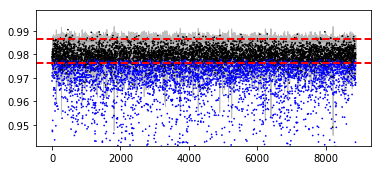

In [7]:
def plot_single_sparse_vs_ci(gene_summary, 
                      method, 
                      pool_perm_intervals, 
                      alpha = 0.5, 
                      fast = False, 
                      save_dir=None):
    ci_df = gene_summary
    grey_col = "grey"

    fig, ax = plt.subplots(1,1,figsize=[6, 2.5])
    name = "Score"
    y_range = [0, 0.8]
    if method == "lap_score":
        name = "Laplacian Score"
        y_range = [0.94, 1]

    if fast:
        ax.plot(ci_df["gene_index"], 
                ci_df["{}_full_pval_left_ci".format(method)], 
                color=grey_col, alpha=alpha)
        ax.plot(ci_df["gene_index"], 
                ci_df["{}_full_pval_right_ci".format(method)], 
                color=grey_col, alpha=alpha)
    else:
        ax.fill_between(ci_df["gene_index"], 
                           ci_df["{}_full_pval_left_ci".format(method)],
                           ci_df["{}_full_pval_right_ci".format(method)],
                           color=grey_col, alpha = 0.5)
    # plot the intervals for the pooled variable permutations
    for i_lr in range(2):
        ax.axhline(pool_perm_intervals[method][i_lr], 
                      color="red", linestyle="--", linewidth=2)
    # plot the scatter plot of signifiant variables
    vals = ci_df[method].values
    vals[vals > y_range[1]] = y_range[1]
    vals[vals < y_range[0]] = y_range[0]
    val_cols = np.repeat("black", len(vals))
    for i_val in range(len(vals)):
        if ci_df.iloc[i_val]["{}_full_pval".format(method)] < 0.05:
            val_cols[i_val] = "blue"
    ax.scatter(ci_df["gene_index"], vals, s=0.5, c=val_cols)
    # more configurations
    ax.set_ylim(y_range[0]+0.001, y_range[1]-0.001)    
    if save_dir:
        assert os.path.exists(save_dir), "folder does not exist"
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        fn = "perm_test_dist_score_sparsity.png"
        fn = os.path.join(save_dir, fn)
        plt.savefig(fn, bbox_inches='tight', dpi=150)
        print("Saved: {}".format(fn))
    plt.show()
plot_single_sparse_vs_ci(full_df, "lap_score", pool_perm_intvls)

dict_keys(['lap_score_full_pval', 'dist_corr_full_pval', 'lap_score_pool_pval', 'dist_corr_pool_pval'])

Number of lap_score_full_pval < 0.05: 4310
Number of dist_corr_full_pval < 0.05: 6632
Intersection between 'full' : 3931

Number of lap_score_pool_pval < 0.05: 4198
Number of dist_corr_pool_pval < 0.05: 6171
Intersection between 'pool' : 3527

Intersection between 'lap_score' : 3876
Intersection between 'dist_corr' : 6127


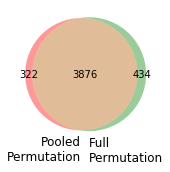

In [10]:
from matplotlib_venn import venn2

def compare_pool_vs_full_vars(gene_summary, cutoff = 0.05):
    metrics = ["lap_score", "dist_corr"]
    sig_sets = {}
    for ptype in ["full", "pool"]:
        print("")  
        for met in metrics:
            pval_col = "{}_{}_pval".format(met, ptype)
            s = set(gene_summary.index[gene_summary[pval_col] < cutoff])
            print("Number of {} < {}: {}".format(pval_col, cutoff, len(s)))
            sig_sets[pval_col] = s
        print("Intersection between '{}' : {}".format(ptype,
           len(sig_sets["lap_score_{}_pval".format(ptype)].intersection(
               sig_sets["dist_corr_{}_pval".format(ptype)]))))
    print("")    
    for met in metrics:
        print("Intersection between '{}' : {}".format(met,
           len(sig_sets["{}_pool_pval".format(met)].intersection(
               sig_sets["{}_full_pval".format(met)]))))
    return sig_sets


def plot_venn(sig_sets, met = "lap_score", save_dir=None):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    lab1 = "{}_pool_pval".format(met)
    lab2 = "{}_full_pval".format(met)
    v = venn2([sig_sets[lab1], sig_sets[lab2]],
              set_labels=("Pooled\nPermutation", "Full\nPermutation"),
              ax=ax)

    plt.tight_layout()
    # assert os.path.exists(save_dir), "folder does not exist"
    if save_dir:
        fn = "perm_test_overlap.pdf"
        fn = os.path.join(save_dir, fn)
        plt.savefig(fn, bbox_inches='tight')
        print("Saved: {}".format(fn))
    plt.show()
print(sig_sets.keys())
sig_sets = compare_pool_vs_full_vars(full_df, cutoff=sig_level)
plot_venn(sig_sets)

## Save figures

Saved: /share/PI/sabatti/feat_viz/main_figs/perm_test_dist_score_sparsity.png


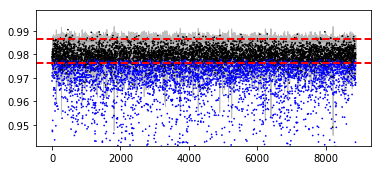

Saved: /share/PI/sabatti/feat_viz/main_figs/perm_test_overlap.pdf


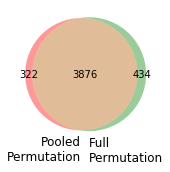

In [9]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"
plot_single_sparse_vs_ci(full_df, "lap_score", pool_perm_intvls, save_dir=FDIR)
plot_venn(sig_sets, met = "lap_score", save_dir=FDIR)